# RL ASSIGNMENET

## Nizar EL GHAZAL

In [1]:
import os
import random
import sys
import time
from collections import defaultdict

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import text_flappy_bird_gym

In [ ]:
def evaluate_agent(agent, env, episodes=100, render=False, sleep=0.05, cap = 100000, greedy = True):
    """
    Evaluates the given agent in the provided environment.
    
    Args:
        agent: the trained agent with a `select_action()` or `get_action()` method
        env: the environment to evaluate in
        episodes: number of episodes to run
        render: whether to render the environment (prints to terminal)
        sleep: delay between frames (if rendering)
        
    Returns:
        List of total rewards per episode
    """
    rewards = []

    for ep in tqdm(range(episodes), desc="Evaluating"):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if greedy:
                action = np.argmax(agent.q[state]) # Assuming agent has a q-table
                # action = agent.greedy_select_action(state) # prefer greedy to epsilon-greedy
            else:
                try:
                    action = agent.get_action(state)
                except :
                    action = agent.get_action(state, _) # for agents with a different signature

            state, reward, done, _, _ = env.step(action)
            total_reward += reward

            if render:
                os.system("clear")
                print(env.render())
                time.sleep(sleep)
                
            if total_reward >= cap:
                done = True # End episode if a high reward is received
                
        rewards.append(total_reward)

    avg_reward = np.mean(rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward:.2f}")
    return rewards

In [12]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
print(obs)
count = 0
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print(obs)  # print the observation (the game state)
    print(f"Action: {action}, Reward: {reward}, Done: {done}, Info: {info}")
    # Render the game
    # os.system("cls")
    # sys.stdout.write(env.render())
    # time.sleep(0.2) # FPS
    count += 1
    # If player is dead break
    if done or count > 100:
        break

env.close()


((13, 0), {'score': 0, 'player': [6, 7], 'distance': 13.0})
(12, 0)
Action: 0, Reward: 1, Done: False, Info: {'score': 0, 'player': [6, 7], 'distance': 12.0}
(11, 2)
Action: 0, Reward: 1, Done: False, Info: {'score': 0, 'player': [6, 9], 'distance': 11.180339887498949}
(10, 6)
Action: 0, Reward: 1, Done: False, Info: {'score': 0, 'player': [6, 13], 'distance': 11.661903789690601}
(9, 8)
Action: 0, Reward: 1, Done: True, Info: {'score': 0, 'player': [6, 15], 'distance': 12.041594578792296}


In [7]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

env.reset()

((13, -5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})

# The SARSA (lambda) agent

In [10]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")

class SarsaAgent:
    def __init__(self, eps, step_size, discount, lambda_):
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        self.lambda_ = lambda_
        
        self.q = defaultdict(lambda : np.zeros(2)) # as our state space is "Small" we will use q_table directly 
        self.z = defaultdict(lambda : np.zeros(2))
        
        self.rewards = []
        self.n_actions = 2 # 0: do nothing, 1: flap
        

    def get_action(self, state):
        """
        epsilon-greedy action selection
        """
        if np.random.uniform(0, 1) < self.eps:
            return np.random.randint(self.n_actions)  # Explore: select a random action
        else:
            return np.argmax(self.q[state])
                    
    def update(self, state, action, reward, next_state, next_action, done, replacing=False):
        """
        Performs the SARSA(λ) update using eligibility traces.
        """
        # Compute TD error
        next_q = 0 if done else self.q[next_state][next_action]
        delta = reward + self.discount * next_q - self.q[state][action]

        # Update eligibility trace
        if replacing:
            self.z[state][action] = 1
        else:
            self.z[state][action] += 1

        # Update Q-values and decay eligibility traces
        for s, traces in self.z.items():
            for a in range(self.n_actions):
                self.q[s][a] += self.step_size * delta * traces[a]
                self.z[s][a] = 0 if done else traces[a] * self.discount * self.lambda_
            

    def train(self, env, episodes=100000, max_steps=1000):
        for _ in tqdm(range(episodes), desc="Training Sarsa Agent"):
            state, _ = env.reset()
            done = False
            total_reward = 0
            self.z = defaultdict(lambda: np.zeros(self.n_actions))  # Reset traces
            action = self.get_action(state)

            for _ in range(max_steps):  # Cap episode length
                next_state, reward, done, _, _ = env.step(action)
                next_action = self.get_action(next_state)
                self.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
                total_reward += reward
                if done:
                    break

            self.rewards.append(total_reward)

    def plot_rewards(self, window_size=500):
        plt.figure(figsize=(12, 6))
        plt.plot(moving_average(self.rewards, window_size), label=f"SARSA (lambda={self.lambda_})")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("SARSA Training Rewards")
        plt.legend()
        plt.grid(True)
        plt.show()  

Training Sarsa Agent: 100%|██████████| 20000/20000 [02:42<00:00, 122.91it/s] 


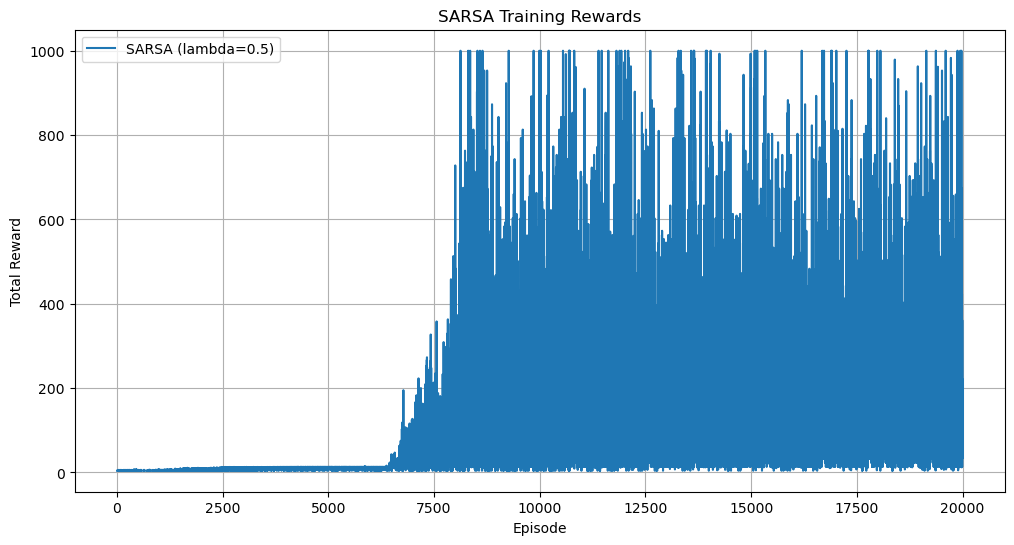

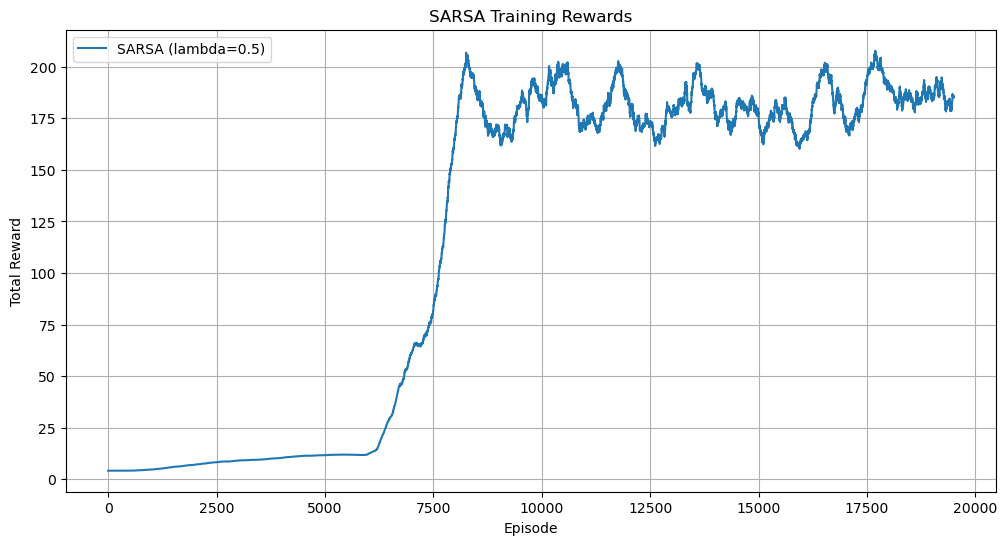

In [11]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

agent_sarsa = SarsaAgent(eps=0.05, step_size=0.2, lambda_= 0.5 , discount=0.99)

agent_sarsa.train(env , episodes=20000)

rewards_sarsa = agent_sarsa.rewards
agent_sarsa.plot_rewards(1)
agent_sarsa.plot_rewards(500)
env.close()

## Effect of $\lambda$

Training Sarsa Agent: 100%|██████████| 10000/10000 [00:55<00:00, 179.38it/s]


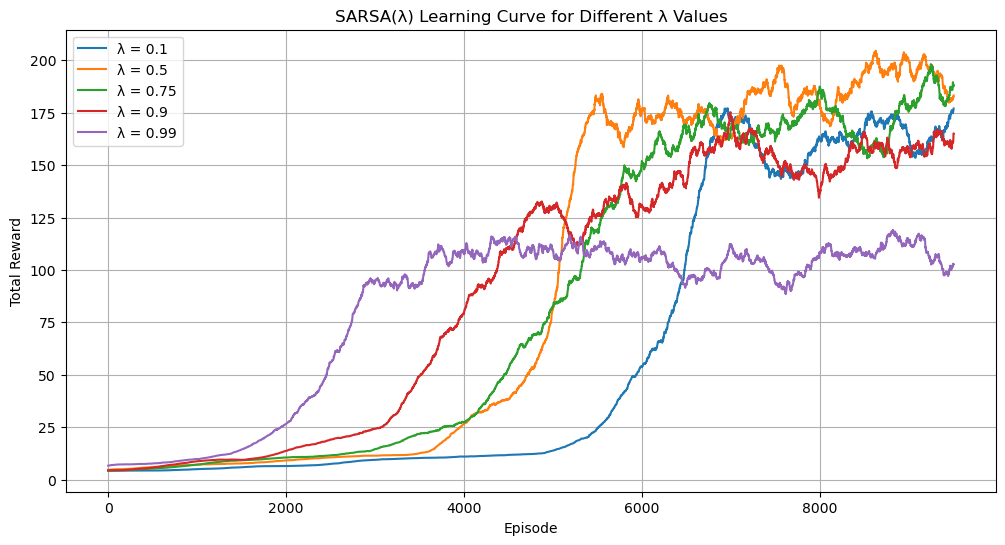

In [16]:
lambdas = [0.1, 0.5, 0.75, 0.9, 0.99]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different λ values
for l in lambdas:
    agent = SarsaAgent(eps=0.05, step_size=0.2, lambda_=l, discount=0.99)
    agent.train(env, episodes=10000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))


for agent, l in zip(agents, lambdas):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"λ = {l}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) Learning Curve for Different λ Values")
plt.legend()
plt.grid(True)
plt.show()


## Effect of epsilon

with different epsilon values, we can't take the learning curve as it is :

suppose epsilon is 5%, in the training, the model has a very high chance to make a mistake earlier over an episode which shows resuls that are worse than what the trained model could achieve in an evaluation setting.

Training Sarsa Agent: 100%|██████████| 10000/10000 [00:05<00:00, 1729.47it/s]


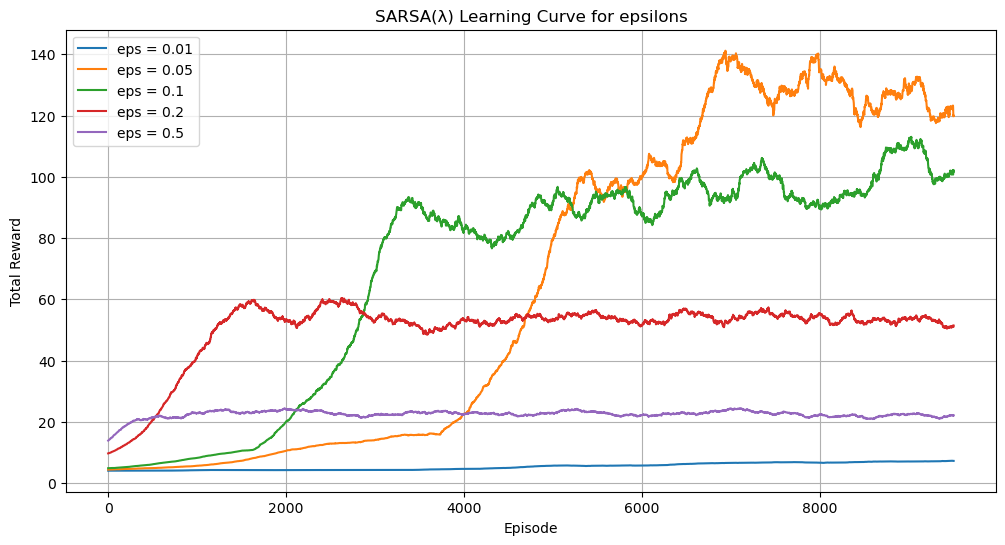

In [69]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different λ values
for eps in epsilons:
    agent = SarsaAgent(eps=eps, step_size=0.2, lambda_=0.5, discount=0.99)
    agent.train(env, episodes=10000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, eps in zip(agents, epsilons):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"eps = {eps}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) Learning Curve for epsilons")
plt.legend()
plt.grid(True)
plt.show()



## Effect of discount on the agent

Training Sarsa Agent: 100%|██████████| 10000/10000 [00:47<00:00, 212.55it/s] 


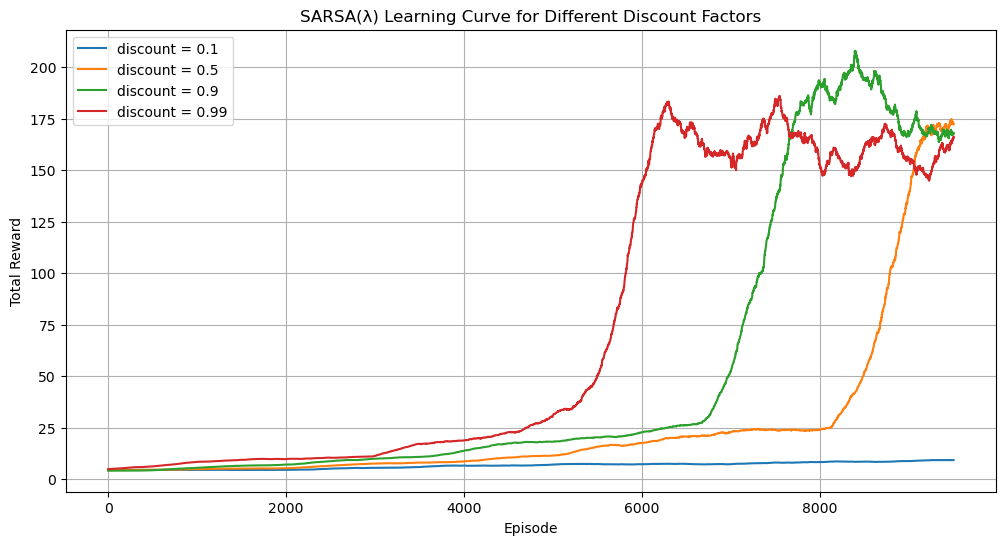

In [18]:
discounts = [0.1, 0.5, 0.9, 0.99]

agents = []
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different discount values

for discount in discounts:
    agent = SarsaAgent(eps=0.05, step_size=0.2, lambda_=0.5, discount=discount)
    agent.train(env, episodes=10000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, discount in zip(agents, discounts):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"discount = {discount}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) Learning Curve for Different Discount Factors")
plt.legend()
plt.grid(True)
plt.show()




## Effect of step size on the agent

Training Sarsa Agent: 100%|██████████| 10000/10000 [01:19<00:00, 125.45it/s]


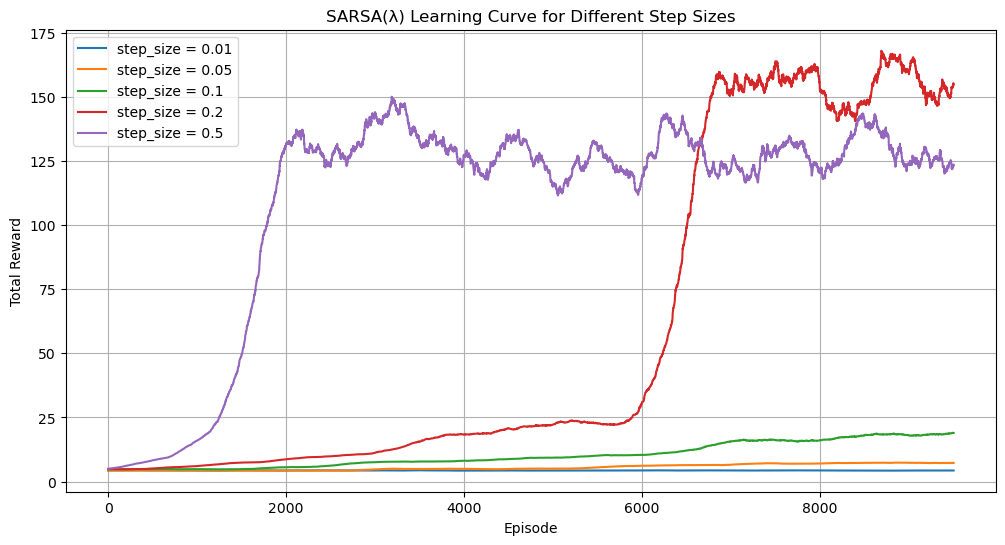

In [19]:
step_sizes = [0.01, 0.05, 0.1, 0.2, 0.5]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different λ values
for step_size in step_sizes:
    agent = SarsaAgent(eps=0.05, step_size=step_size, lambda_=0.5, discount=0.9)
    agent.train(env, episodes=10000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, step_size in zip(agents, step_sizes):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"step_size = {step_size}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) Learning Curve for Different Step Sizes")
plt.legend()
plt.grid(True)
plt.show()

## Plotting the surface value function

We train the model with the best parameters we found so far; assuming independance between these parameters

In [70]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection


def plot_surface_value(V):
    """
    Plots a 3D surface for V(x, y), where state = (x, y)
    """
    # Extract all x and y values
    xs = [state[0] for state in V.keys()]
    ys = [state[1] for state in V.keys()]
    
    x_range = np.arange(min(xs), max(xs) + 1)
    y_range = np.arange(min(ys), max(ys) + 1)
    
    X, Y = np.meshgrid(x_range, y_range)
    
    # Build Z (value) matrix using V(x, y)
    Z = np.array([
        [V.get((x, y)) for x in x_range]
        for y in y_range
    ])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=plt.cm.coolwarm, edgecolor='k')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('V(x, y)')
    ax.set_title('State-Value Function 3D Plot')
    ax.view_init(elev=30, azim=135)
    
    fig.colorbar(surf)
    plt.tight_layout()
    plt.show()

Training Sarsa Agent: 100%|██████████| 15000/15000 [02:32<00:00, 98.24it/s]  


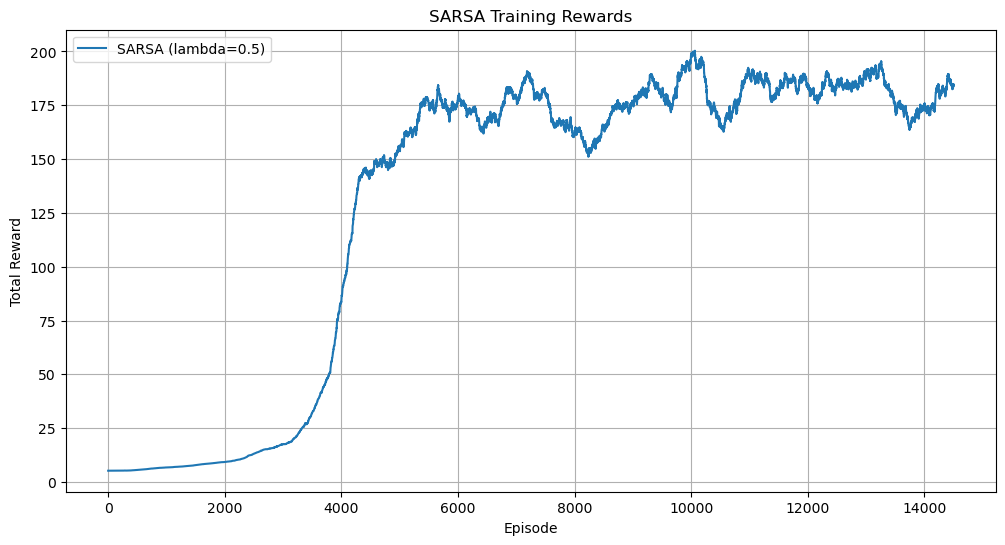

In [39]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset() 

sarsa_agent_final = SarsaAgent(eps=0.05, step_size=0.2, lambda_=0.5, discount=0.9)
sarsa_agent_final.train(env, episodes=15000)

env.close()
sarsa_agent_final.plot_rewards(500)

## Evaluation

for this, we use greedy selection, since we  the best performance and we don't care about exploration

In [42]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
#evaluate the agent
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False)

Evaluating: 100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

Average Reward over 100 episodes: 100000.00


We selected 100000 as a reward cap in an episode since the evaluation would take too long otherwise.

We also tried other arbitrary caps such as 1000000 or even higher but the model was always able to reach that cap

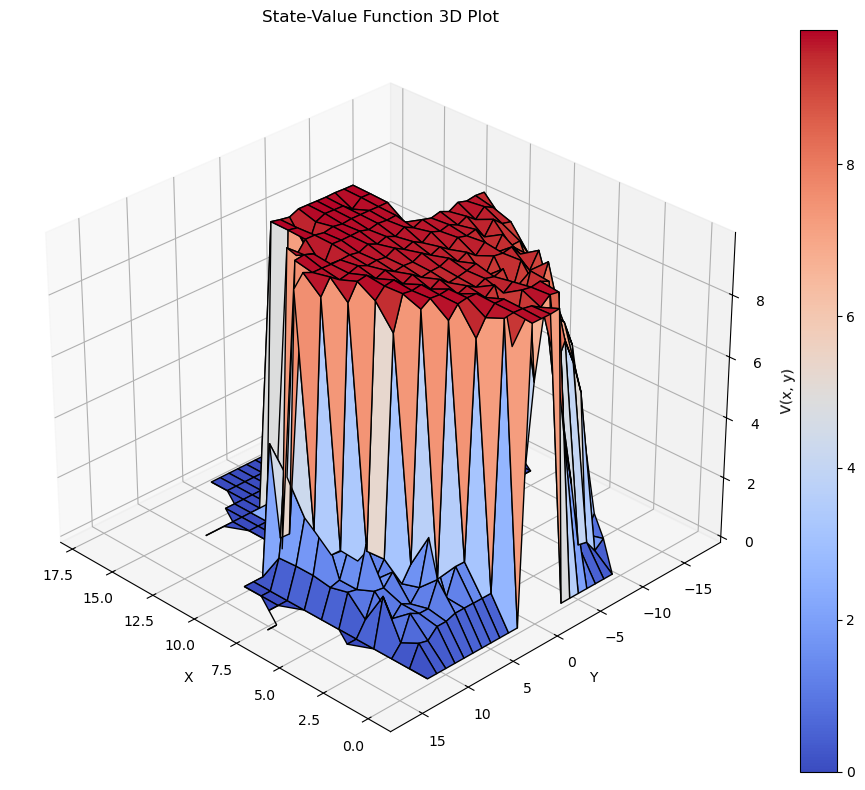

In [71]:
V = {state: np.max(q_values) for state, q_values in sarsa_agent_final.q.items()}

plot_surface_value(V)

# Monte Carlo Agent

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class MCAgent:
    def __init__(self, eps=0.1, step_size=0.1, discount=0.99):
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        self.q = defaultdict(lambda: np.zeros(2))
        self.episode = []
        self.rewards = []
        self.n_actions = 2  # 0: do nothing, 1: flap

    def get_action(self, state, action_space):
     
        if np.random.uniform(0, 1) < self.eps:
            return np.random.randint(self.n_actions)  # Explore: select a random action
        else:
            return np.argmax(self.q[state])

    def store(self, state, action, reward):
        
        self.episode.append((state, action, reward))

    def update(self):
        G = 0
        visited = set()
        for state, action, reward in reversed(self.episode):
            G = self.discount * G + reward
            if (state, action) not in visited:
                self.q[state][action] += self.step_size * (G - self.q[state][action])
                visited.add((state, action))
        self.episode = []

    def train(self, env, num_episodes=10000, max_steps=1000):
        reward_sums = []

        for episode in tqdm(range(num_episodes), desc="Monte Carlo Training"):
            state, _ = env.reset()
            total_reward = 0

            for _ in range(max_steps):
                action = self.get_action(state, env.action_space)
                next_state, reward, done, _, _ = env.step(action)

                self.store(state, action, reward)

                state = next_state
                total_reward += reward
                if done:
                    break
                
            self.update()
            reward_sums.append(total_reward)

        self.rewards = reward_sums
        return reward_sums

    def plot_monte_carlo_rewards(self, window_size=50):
        plt.figure(figsize=(12, 6))
        plt.plot(moving_average(self.rewards, window_size),
                 label=f"Moving Average (window={window_size})")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Monte Carlo Training Rewards")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Monte Carlo Training: 100%|██████████| 150000/150000 [05:52<00:00, 425.21it/s] 


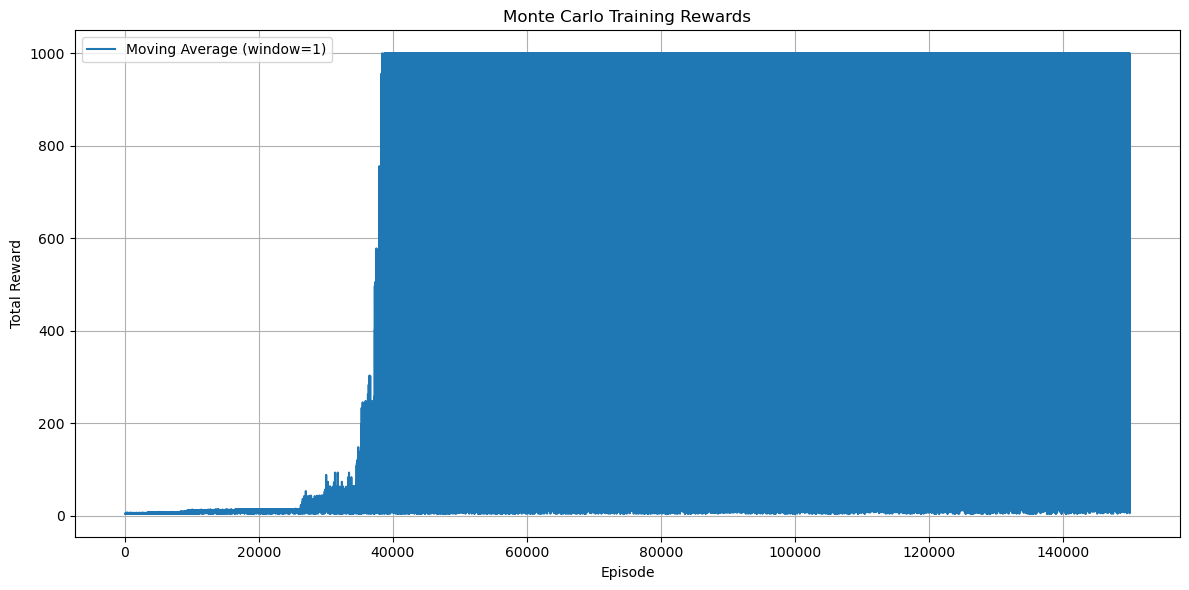

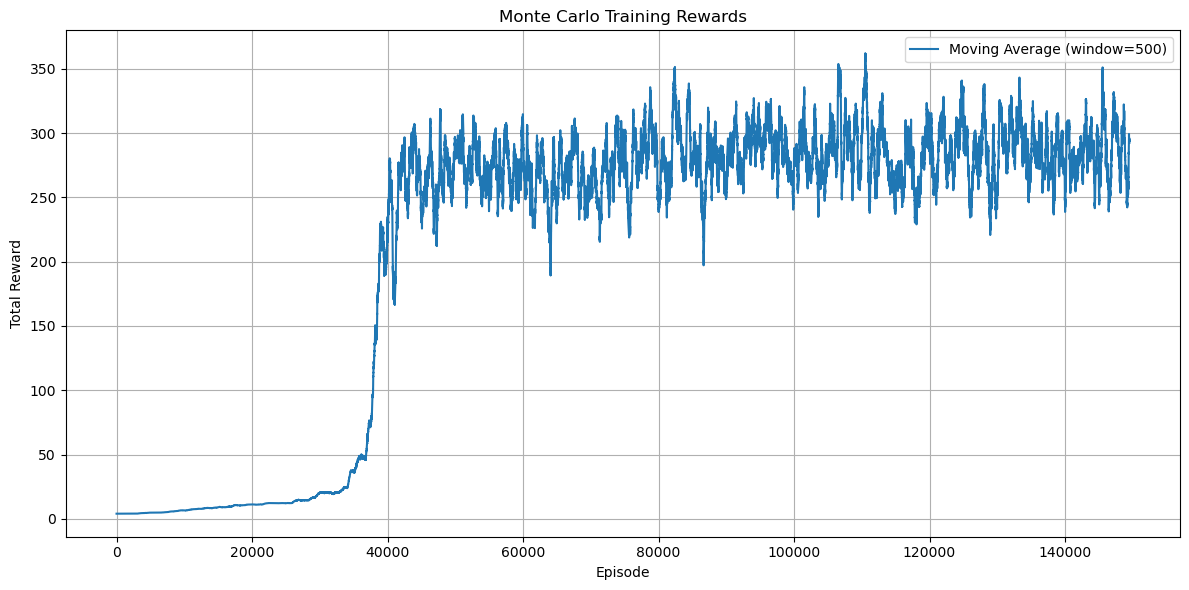

In [47]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent_MC = MCAgent(eps=0.01, discount=0.99)
agent_MC.train(env , num_episodes=150000)

agent_MC.plot_monte_carlo_rewards(1)
agent_MC.plot_monte_carlo_rewards(500)
env.close()

## Effect of epsilon

same applies as above for epsilon

Monte Carlo Training: 100%|██████████| 75000/75000 [00:16<00:00, 4485.88it/s]


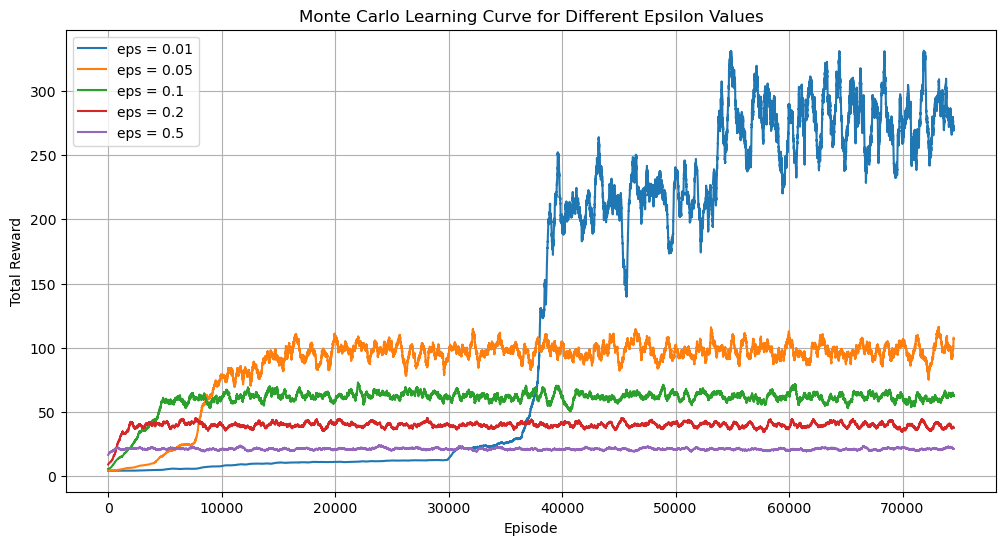

In [48]:
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()

# Train agents with different epsilon values
for eps in epsilons:
    agent = MCAgent(eps=eps, step_size=0.1, discount=0.99)
    agent.train(env, num_episodes=75000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, eps in zip(agents, epsilons):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"eps = {eps}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Monte Carlo Learning Curve for Different Epsilon Values")
plt.legend()
plt.grid(True)
plt.show()

## Effect of discount

Monte Carlo Training: 100%|██████████| 75000/75000 [01:22<00:00, 908.07it/s]  


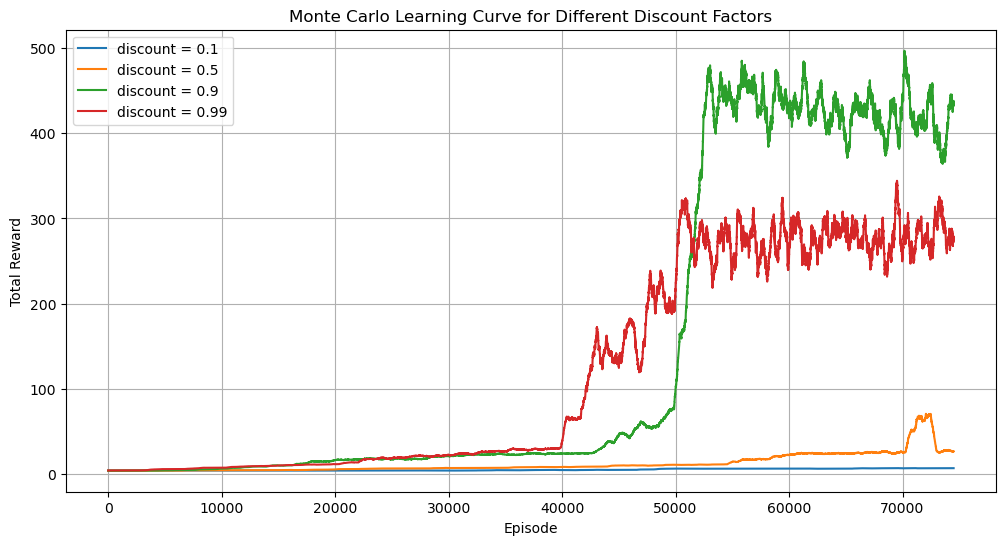

In [49]:
discounts = [0.1, 0.5, 0.9, 0.99]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different discount values
for discount in discounts:
    agent = MCAgent(eps=0.01, step_size=0.1, discount=discount)
    agent.train(env, num_episodes=75000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, discount in zip(agents, discounts):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"discount = {discount}")
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Monte Carlo Learning Curve for Different Discount Factors")
plt.legend()
plt.grid(True)
plt.show()


## effect of step size

Monte Carlo Training: 100%|██████████| 75000/75000 [04:10<00:00, 298.88it/s] 


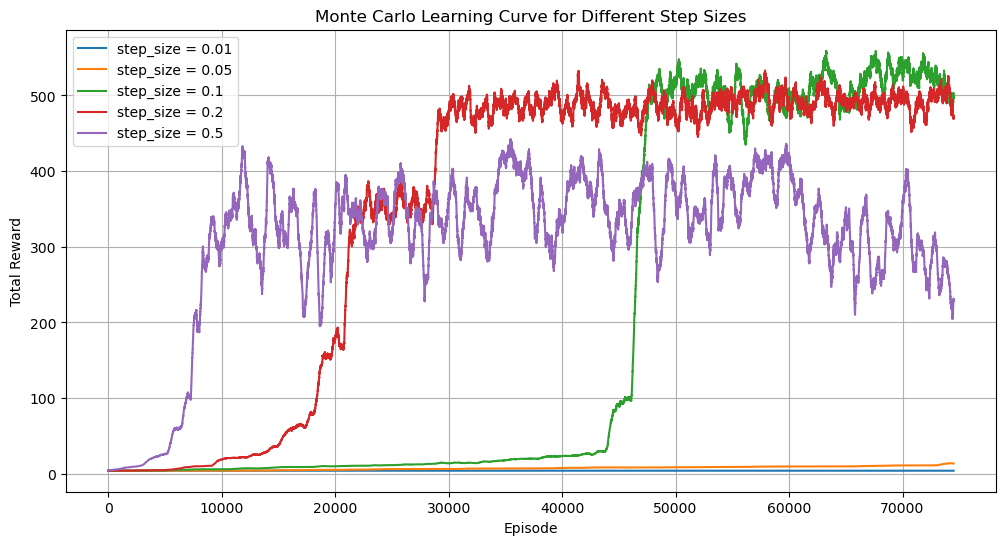

In [50]:
step_sizes = [0.01, 0.05, 0.1, 0.2, 0.5]
agents = []

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
env.reset()
# Train agents with different step sizes

for step_size in step_sizes:
    agent = MCAgent(eps=0.01, step_size=step_size, discount=0.9)
    agent.train(env, num_episodes=75000)
    agents.append(agent)
    
env.close()
# Plotting the results
plt.figure(figsize=(12, 6))

for agent, step_size in zip(agents, step_sizes):
    rewards = agent.rewards
    moving_average_rewards = moving_average(rewards, 500)
    
    plt.plot(moving_average_rewards, label=f"step_size = {step_size}")  
    
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Monte Carlo Learning Curve for Different Step Sizes")
plt.legend()
plt.grid(True)
plt.show()

## Training a model with the best parameters

Monte Carlo Training: 100%|██████████| 150000/150000 [04:15<00:00, 585.98it/s]


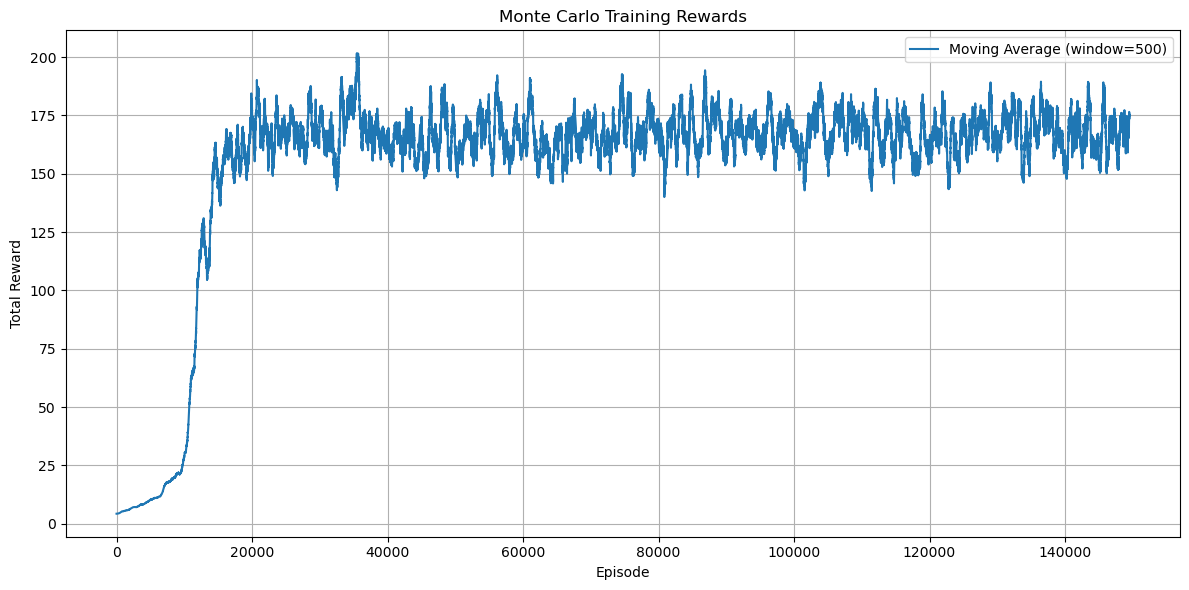

In [53]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
mc_agent_final = MCAgent(eps=0.05, step_size=0.1, discount=0.9)
mc_agent_final.train(env, num_episodes=150000)
env.close()

mc_agent_final.plot_monte_carlo_rewards(500)

In [54]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False)
env.close()

Evaluating: 100%|██████████| 100/100 [00:57<00:00,  1.74it/s]

Average Reward over 100 episodes: 100000.00


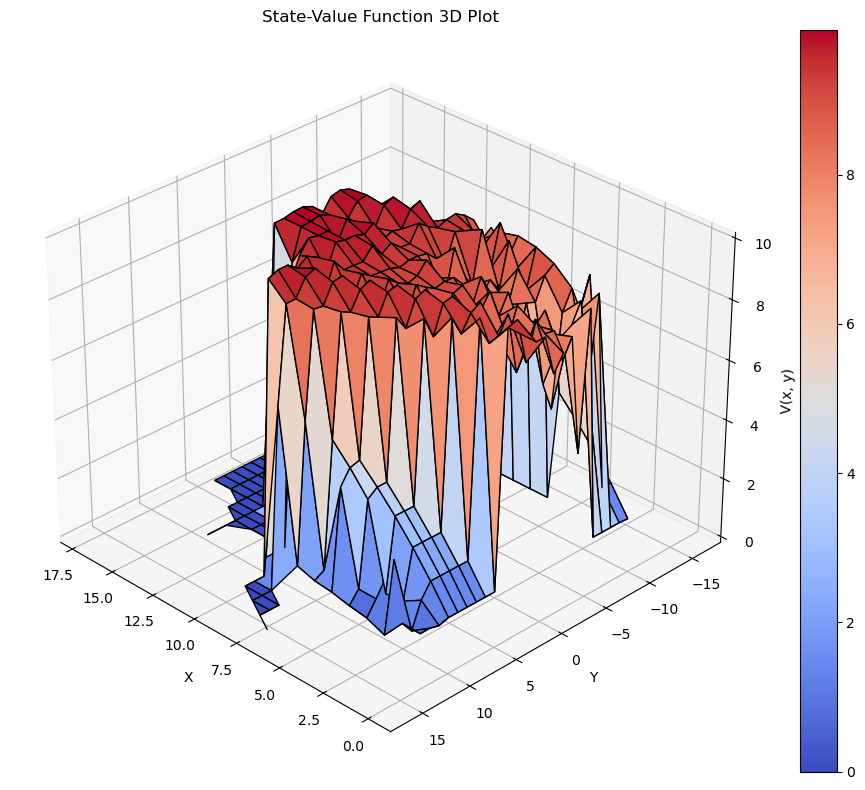

In [73]:
V = {state: np.max(q_values) for state, q_values in mc_agent_final.q.items()}

plot_surface_value(V)

# Testing the final models on different environments

In [61]:
# test the agents on different environments
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=3)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False)
env.close()


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 2803.90it/s]


Average Reward over 100 episodes: 54.32


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 2645.85it/s]

Average Reward over 100 episodes: 49.36


In [62]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=5)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False, cap = 10000)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False, cap = 10000)
env.close()

Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


Average Reward over 100 episodes: 10000.00


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.30it/s]

Average Reward over 100 episodes: 10000.00


In [67]:
env = gym.make('TextFlappyBird-v0', height=20, width=20, pipe_gap=4)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False, cap = 10000)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False, cap = 10000)
env.close()

Evaluating: 100%|██████████| 100/100 [00:00<00:00, 489.92it/s]


Average Reward over 100 episodes: 304.55


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 1001.29it/s]

Average Reward over 100 episodes: 181.75


In [68]:
env = gym.make('TextFlappyBird-v0', height=15, width=15, pipe_gap=4)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False, cap = 10000)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False, cap = 10000)
env.close()

Evaluating: 100%|██████████| 100/100 [00:01<00:00, 95.47it/s]


Average Reward over 100 episodes: 1688.04


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 46.55it/s]

Average Reward over 100 episodes: 3457.98


## Bonus : Greedy vs Epsilon greedy in evaluation

In [77]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False, cap = 10000)
_ = evaluate_agent(sarsa_agent_final, env, episodes=100, render=False, cap = 10000, greedy = False)

_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False, cap = 10000)
_ = evaluate_agent(mc_agent_final, env, episodes=100, render=False, cap = 10000, greedy = False)
env.close()

Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


Average Reward over 100 episodes: 10000.00


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 757.49it/s]


Average Reward over 100 episodes: 178.56


Evaluating: 100%|██████████| 100/100 [00:07<00:00, 12.65it/s]


Average Reward over 100 episodes: 10000.00


Evaluating: 100%|██████████| 100/100 [00:00<00:00, 533.84it/s]

Average Reward over 100 episodes: 158.59


Note the difference that epsilon greedy selection makes during evaluation.

A similar effect (to an extent) could be seen also during training, for example if we look at the training curve for MC with epsilon = 0.01 and epsilon = 0.05, it looks like epsilon = 0.01 is better although slower at converging.
In reality, if we evaluate the model, epsilon 0.01 gives way worse results, below 1000 average (while the rewards cap is much higher) while with epsilon = 0.05, the model was able to reach any arbitrary cap we set (10k, 100k and even 1 million)